In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import inspect

import torch
import torch.distributions as dist
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

SEED=3012024

In [ ]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [ ]:
torch.manual_seed(SEED)


## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld, norm = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld} CB Norm = {norm}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [ ]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld, _ = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE=="cuda" else {}

batch_size = 128

train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size, shuffle=False, **kwargs)

In [ ]:
EPOCHS=30
clamp_threshold = 1e-4 # implemented in the original cb work
# 3.) modify the network architecture and try to obtain a better embedding
model = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Jeg har simplificeret udtrykket en smule og tilføjet ledet til loss-funktionen
def sumLogC(x, distance=0.01):
    mask = torch.isclose(x, torch.tensor(0.5), rtol=0, atol=distance)
    close = x[mask]
    not_close = x[~mask]
    # Taylor exspansion omkring 1/2, skal nok dobbeltjekkes
    logC_close = torch.log(2.0 + 8.0/3.0 * (close-0.5)**2.0 + 32.0/5.0 * (close-0.5)**4.0)
    # logC_close = torch.ones_like(x)*torch.log(torch.tensor(2.0)) # Man kunne måske bare tage dem der er lig 0.5, og sætte dem lige 2
    # logC_not_close = torch.log((torch.log(1.0-not_close) - torch.log(not_close))/(1.0-2.0*not_close))
    logC_not_close = torch.log(2 * torch.atanh(1- 2*not_close)/(1.0-2.0*not_close))
    return logC_close.sum() + logC_not_close.sum()


def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    x = x.view(-1, 784)
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    recon_x = torch.clamp(recon_x, clamp_threshold, 1-clamp_threshold) # implemented in the original cb work
    cb_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    normalization = (-1) * sumLogC(recon_x)
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return cb_loss + normalization + KLD, cb_loss, KLD, normalization # = -ELBO


train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model, epoch=e, train_loader=train_loader)
    test_loss_vals = test(model, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=2.4787521362304688
BCE=69995.46875 KLD=1.8271496295928955 CB Norm = -69680.015625
Train epoch=1 [3200/60000]	 loss=-981.3468627929688
BCE=48955.3046875 KLD=13215.9453125 CB Norm = -187783.65625
Train epoch=1 [6400/60000]	 loss=-1114.7799072265625
BCE=42134.8671875 KLD=1691.3885498046875 CB Norm = -186518.09375
Train epoch=1 [9600/60000]	 loss=-1088.570556640625
BCE=41238.15234375 KLD=1639.65478515625 CB Norm = -182214.84375
Train epoch=1 [12800/60000]	 loss=-1102.2615966796875
BCE=40654.2109375 KLD=1704.0537109375 CB Norm = -183447.734375
Train epoch=1 [16000/60000]	 loss=-1099.068359375
BCE=40629.29296875 KLD=1415.0009765625 CB Norm = -182725.046875
Train epoch=1 [19200/60000]	 loss=-1123.693115234375
BCE=36632.9921875 KLD=1415.8466796875 CB Norm = -181881.546875
Train epoch=1 [22400/60000]	 loss=-1147.1744384765625
BCE=35596.5078125 KLD=1284.200439453125 CB Norm = -183719.046875
Train epoch=1 [25600/60000]	 loss=-1166.8524169921875
BCE=35929.58203125 KLD

-167265.53149986675
-164853.46439873418


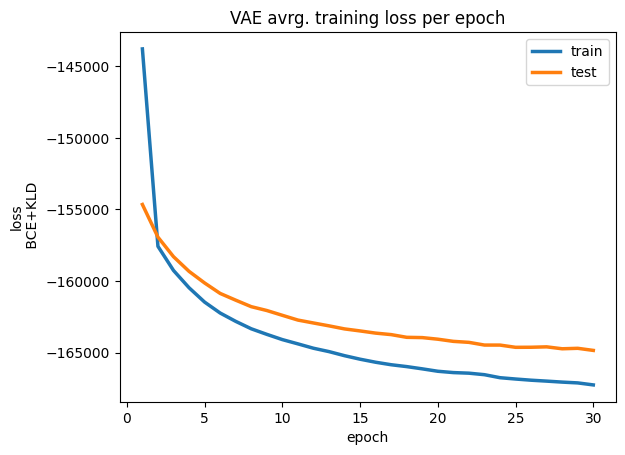

In [ ]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls)/batch_size for ls in train_loss_vals_total], lw=2.5, label="Train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls)/batch_size for ls in test_loss_vals_total], lw=2.5, label="Test")
print([np.mean(ls)/batch_size for ls in train_loss_vals_total][-1])
print([np.mean(ls)/batch_size for ls in test_loss_vals_total][-1])
plt.xlabel("Epochs")
plt.ylabel("Loss / -ELBO")
# plt.yscale("log")
plt.title("VAE with continuous Bernoulli avrg. loss per epoch")
plt.legend()
plt.show()

In [ ]:
# encode entries
latent_coordinates = []
for data in train_data:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model.encode(data[0].to(DEVICE).view(-1, 784))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates).reshape(60000, -1)

In [ ]:
latent_coordinates = latent_coordinates.reshape(60000, -1)
train_labels = [data[1] for data in train_data]

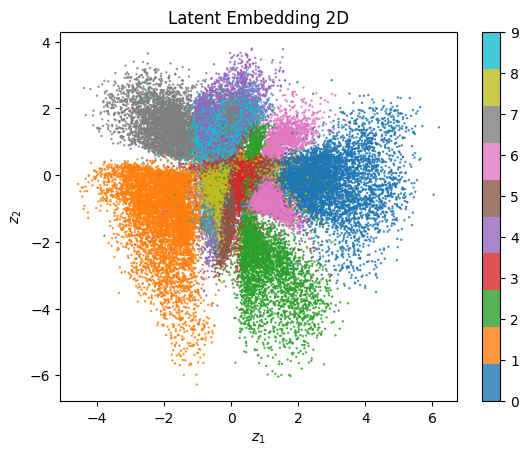

In [ ]:
# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

### Visualization by Gauss CDF

In [ ]:
## 2.) visualize across Gaussian CDF
n_cols = 12
z_space = torch.linspace(0.001, 0.999, n_cols) # for 5x5 grid
std_gauss = torch.distributions.normal.Normal(0, 1)

xx, yy = torch.meshgrid(z_space, z_space, indexing = "ij")

zz_gauss_cdf_vals = torch.dstack([std_gauss.icdf(xx), std_gauss.icdf(yy)]).reshape(-1, 2)
zz_gauss_cdf_vals.shape

torch.Size([144, 2])

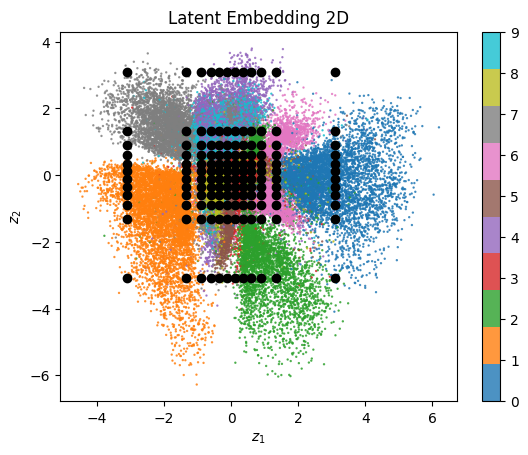

In [ ]:
train_labels = [data[1] for data in train_data]

plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.colorbar()
plt.scatter(zz_gauss_cdf_vals[:,0], zz_gauss_cdf_vals[:,1], color='black')
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.title("Latent Embedding 2D")
plt.show()

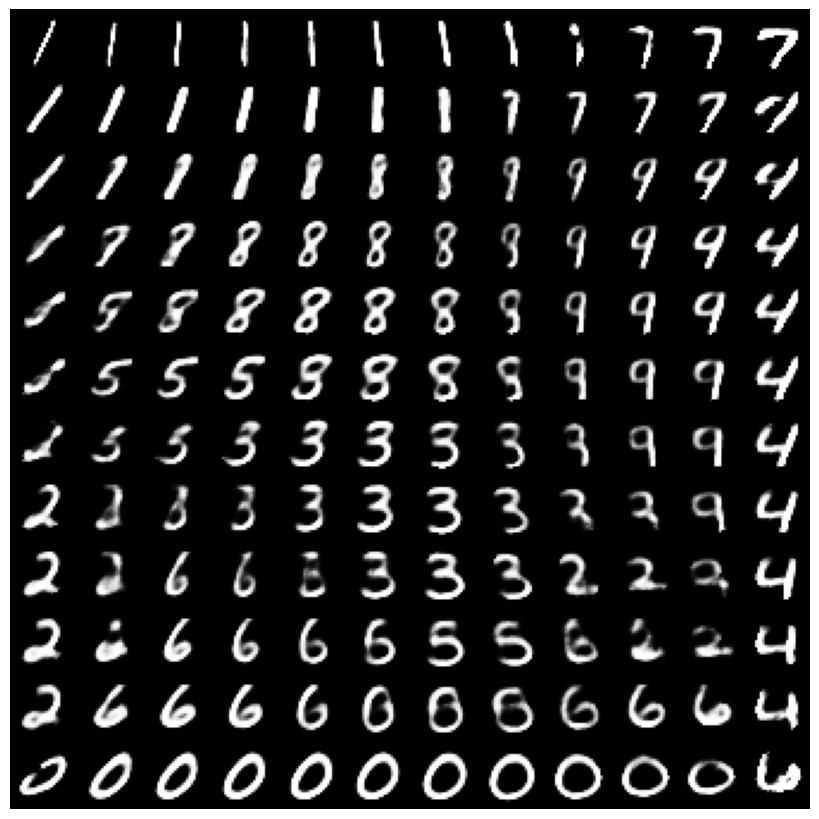

In [ ]:
fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))

def mu_cb(lamb):
    return lamb/(2*lamb-1) + 1/(2*torch.atanh(1- 2*lamb))

k = 0
for i in range(n_cols):
    for j in range(n_cols):
        _zz = zz_gauss_cdf_vals[k]
        #reconstruction = mu_cb(model.decode(_zz.to(DEVICE)).cpu().detach()).numpy()
        reconstruction = model.decode(_zz.to(DEVICE)).cpu().detach().numpy()
        img = reconstruction.reshape((28,28))
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].set_axis_off()
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k += 1
# plt.suptitle("MNIST reconstruction")
plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.show()

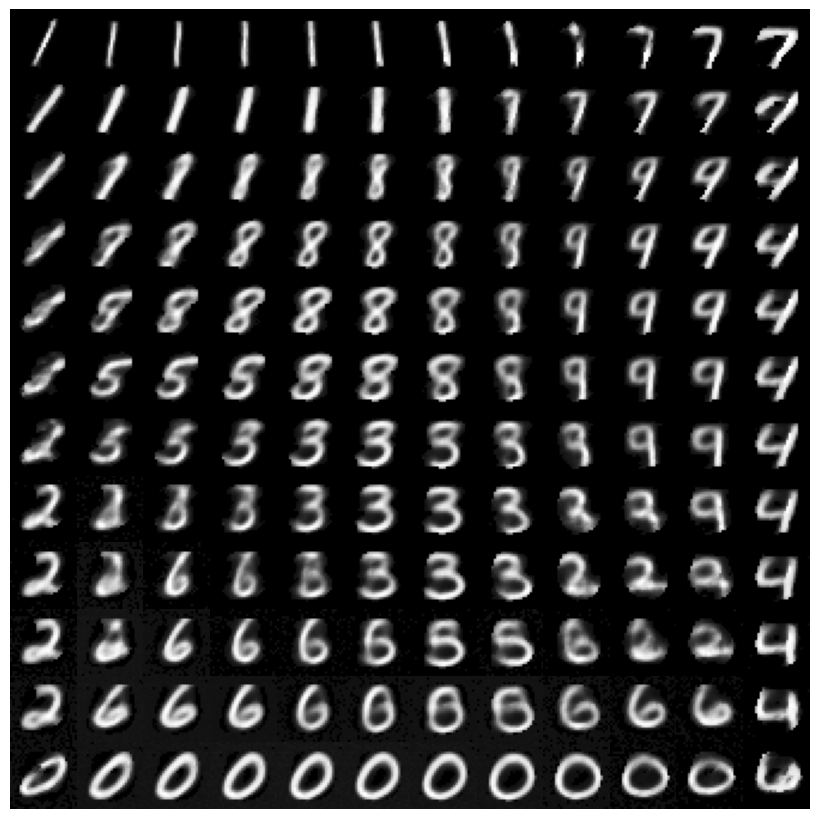

In [ ]:
fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))

def mu_cb(lamb):
    return lamb/(2*lamb-1) + 1/(2*torch.atanh(1- 2*lamb))

k = 0
for i in range(n_cols):
    for j in range(n_cols):
        _zz = zz_gauss_cdf_vals[k]
        reconstruction = mu_cb(model.decode(_zz.to(DEVICE)).cpu().detach()).numpy()
        #reconstruction = model.decode(_zz.to(DEVICE)).cpu().detach().numpy()
        img = reconstruction.reshape((28,28))
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].set_axis_off()
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k += 1
# plt.suptitle("MNIST reconstruction")
plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.title('lol')
plt.show()

In [ ]:
def LogC(x, distance=0.01):
    LogC_tensor = torch.zeros_like(x)
    mask = torch.isclose(x, torch.tensor(0.5), rtol=0, atol=distance)
    close = x[mask]
    not_close = x[~mask]
    # Taylor exspansion omkring 1/2, skal nok dobbeltjekkes
    logC_close = torch.log(2.0 + 8.0/3.0 * (close-0.5)**2.0 + 32.0/5.0 * (close-0.5)**4.0)
    # logC_close = torch.ones_like(x)*torch.log(torch.tensor(2.0)) # Man kunne måske bare tage dem der er lig 0.5, og sætte dem lige 2
    # logC_not_close = torch.log((torch.log(1.0-not_close) - torch.log(not_close))/(1.0-2.0*not_close))
    logC_not_close = torch.log(2 * torch.atanh(1- 2*not_close)/(1.0-2.0*not_close))
    LogC_tensor[mask] = logC_close
    LogC_tensor[~mask] = logC_not_close
    return LogC_tensor

In [ ]:
def marginal_likelihood(data, model, N=128):
    log_p_xs = torch.zeros(len(data))
    for i, (image, _) in enumerate(data):
        mu, logvar = model.encode(image.to(DEVICE).view(-1, 784))
        mu = mu.cpu().detach()
        logvar = logvar.cpu().detach()
        var = torch.exp(logvar)
        q = dist.MultivariateNormal(mu, var * torch.eye(2))
        z = q.sample((N,))
        log_p_z = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).log_prob(z)
        log_q_z = q.log_prob(z)
        lam = model.decode(z.to(DEVICE)).cpu().detach()
        lam = torch.clamp(lam, clamp_threshold, 1-clamp_threshold) # Vi clamper for at undgå inf værdier i normaliseringskonstanten
        log_p_cb = torch.sum((-1) * F.binary_cross_entropy(lam, image.view(-1, 784).repeat(N, 1, 1), reduction="none") + LogC(lam), axis=2)
        log_something = log_p_cb + log_p_z - log_q_z
        log_p_x = -np.log(N) + torch.logsumexp(log_something, dim=0)
        log_p_xs[i] = log_p_x[0]
    return log_p_xs.mean()

In [ ]:
# Det virker måske rigtigt nok. Den er ihvertfald omkring ELBO.
print('marginal likelihood: ', marginal_likelihood(test_data, model, N=128))

tensor(1308.0667)